# Vehicle Routing

Logistics is a major industry valued at over $8 billion USD globally. Most service providers operate a number of vehicles (e.g., trucks and container ships), a number of depots, where the vehicles are based overnight, and serve a number of client locations with each vehicle during each day. The key challenge is how to optimize routes from depots to a number of client locations and back to the depot, so as to minimize vehicle-miles traveled, time spent, or similar objective functions. Ths demo shows an idealized version of the problem and showcase its solution using the Quantum Approximate Optimization Approach (QAOA) of Farhi, Goldstone, and Gutman (2014).

In [31]:
# Initialize the problem by defining the parameters
n = 4  # number of nodes + depot (n+1) MAX: 3 for quantum system, 2 for Noise Model
K = 2  # number of vehicles MAX: 2 for quantum system, 2 for Noise Model
backend_type = 'quantum' #Set whether to use quantum or simulator backend, 
                             #Set to 'quantum' for QC hardware, Set to 'noise' for noise simulation

## Import necessary libraries to run program

In [32]:
# Load the packages that are required
import numpy as np
import operator
import matplotlib.pyplot as plt

import sys
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')

import math

# Qiskit packages
from qiskit import BasicAer
from qiskit.quantum_info import Pauli
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.optimization.algorithms import CobylaOptimizer, MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.optimization.applications.ising.vehicle_routing import get_operator, get_vehiclerouting_cost, \
    get_vehiclerouting_matrices, get_vehiclerouting_solution  
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.problems import QuadraticProgram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
# setup aqua logging
import logging
from qiskit.aqua._logging import set_logging_config, build_logging_config
#set_logging_config(build_logging_config(logging.DEBUG))  # choose INFO, DEBUG to see the log

#import to generate random numbers
from random import randrange

In [33]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ, assemble, transpile
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-03-11 20:06:26,942: Credentials are already in use. The existing account in the session will be replaced.


## Define functions used in program

In [34]:
# Get the data
class Initializer():

    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
        
    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)    
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))
        
def cost_sol(result):    
    cost=result.fval
    solution_float=result.x
    solution = solution_float.astype(int)

    #Data Visualization
    x_quantum = np.zeros(n**2)
    kk = 0
    for ii in range(n ** 2):
        if ii // n != ii % n:
            x_quantum[ii] = solution[kk]
            kk +=  1
    return x_quantum, solution, cost

def cost_sol_step2(result_vqe, result_qaoa):    
    cost_vqe=result_vqe.fval
    solution_float=result_vqe.x
    solution_vqe = solution_float.astype(int)
    
    if cost_vqe == cost_clas:
        vqe_eval = "equivalent"
    elif cost_vqe > cost_clas:
        vqe_eval = 'worse'
    elif cost_vqe < cost_clas:
        vqe_eval = 'better'
    else:
        qaoa_eval = 'unknown'
        
    x_quantum_vqe = np.zeros(n**2)
    kk = 0
    for ii in range(n ** 2):
        if ii // n != ii % n:
            x_quantum_vqe[ii] = solution_vqe[kk]
            kk +=  1
    
    cost_qaoa=result_vqe.fval
    solution_float=result_qaoa.x
    solution_qaoa = solution_float.astype(int)

    if cost_qaoa == cost_clas:
        qaoa_eval = "equivalent"
    elif cost_qaoa > cost_clas:
        qaoa_eval = 'worse'
    elif cost_qaoa < cost_clas:
        qaoa_eval = 'better'
    else:
        qaoa_eval = 'unknown'   

    #Data Visualization
    x_quantum_qaoa = np.zeros(n**2)
    kk = 0
    for ii in range(n ** 2):
        if ii // n != ii % n:
            x_quantum_qaoa[ii] = solution_qaoa[kk]
            kk +=  1
            
    print('-------------------------------------------------------')
    print('Classical Optimal value {:.4f}'.format(cost_clas))
    print('-------------------------------------------------------')
    print('QAOA performs', qaoa_eval, 'to classical computer algorithm with value = {:.4f}'.format(cost_qaoa))
    print(' ')          
    print('VQE performs', vqe_eval, 'than classical computer algorithm with value = {:.4f}'.format(cost_vqe))
    print('---------------------------------------------------')
    
    return x_quantum_qaoa, solution_qaoa, cost_qaoa, x_quantum_vqe, solution_vqe, cost_vqe 

# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid(b=None)
    plt.axis('off')

    for ii in range(0, n ** 2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25)

    plt.title(title_str+'optimal solution with cost value = ' + str(int(C * 100) / 100.))
    plt.show()    

def backends(flag):
    provider = IBMQ.load_account()
    provider2 = IBMQ.get_provider(hub='ibm-q-deloitte') #, group='internal', project='deloitte-us-quan')    
    if flag.lower() == 'quantum':
        backend = provider2.get_backend('ibmq_casablanca')
        coupling_map = None
        noise_model = None

    elif flag.lower() == 'noise': 
        device_backend = FakeVigo()
        backend = Aer.get_backend('qasm_simulator')
        counts1 = []
        values1 = []
        noise_model = None
        os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
        device = QasmSimulator.from_backend(device_backend)
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)
        basis_gates = noise_model.basis_gates
    
    else:
        backend = Aer.get_backend('statevector_simulator')
        coupling_map = None
        noise_model = None
    return backend, coupling_map, noise_model

In [35]:
# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc,yc,instance = initializer.generate_instance()
backend, coup_map, noise_mod = backends(backend_type) #Set whether to use quantum or simulator backend, 
                                #Set to 'quantum' for QC hardware, Set to 'noise' for noise simulation

ibmqfactory.load_account:WARNING:2021-03-11 20:06:30,804: Credentials are already in use. The existing account in the session will be replaced.


## Create Ising Hamiltonian and routing matrix  
To use a Variational Combinatorial Problem, the problem needs to be encoded into an Ising Hamiltonian usable by the quantum algorithm. An Ising Hamiltonian can be input into quantum optimizers such as VQE and QAOA. The Get_operator function is the term that creates the Ising Hamiltonian that can be fed into QAOA and VQE. For more information about <a href="https://repository.tudelft.nl/islandora/object/uuid%3A7438bfdc-7837-47a0-83fd-e14e09bef714"> Ising Hamiltonians and QAOA in digestible form, see this link. </a>

In [36]:
veh_ising = get_operator(instance, n, K) #Convert weight_matrix, using values of n (nodes) and K (Vehicles)
veh_matrix = get_vehiclerouting_matrices(instance, n, K) #Construct auxxiliary matricies from a vehicle instance to create 
                                                         #binar quadratic program, constructions qubit ops and compute 
                                                         #solution cost 
offset_veh = veh_matrix[2] #Get  offset value from veh_matrix
#print('Ising Hamiltonian:')
#print(veh_ising.print_details())
#print('Matrix')
#print(veh_matrix)

In [37]:
mod = QuadraticProgram()
for i in range(n * (n - 1)):
  mod.binary_var(str(i))
mod.minimize(constant=veh_matrix[2], linear=veh_matrix[1], quadratic=veh_matrix[0])

aqua_globals.random_seed = 10598

quantum_instance = QuantumInstance(backend,
 seed_simulator=aqua_globals.random_seed,
 seed_transpiler=aqua_globals.random_seed, 
 coupling_map=coup_map,  
 noise_model=noise_mod,)

## Create Classical Result

In [38]:
#Classic option
exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)
exact_result = exact.solve(mod)
#print("\nNumpy Classic Minimum Eigensolver:\n", exact_result)

x_quantum_clas, solution_clas, cost_clas = cost_sol(exact_result)

## QAOA Solution
Mathematically speaking, the vehicle routing problem (VRP) is a combinatorial problem, wherein the best routes from a depot to a number of clients and back to the depot are sought, given a number of available vehicles. Here, we present a formulation known as MTZ [Miller, Tucker, Zemlin, 1960]. we demonstrate an approach that combines classical and quantum computing steps, following the quantum approximate optimization approach of Farhi, Goldstone, and Gutman (2014). In particular, we use the variational quantum eigensolver (VQE). We stress that given the use of limited depth of the quantum circuits employed (variational forms), it is hard to discuss the speed-up of the algorithm, as the solution obtained is heuristic in nature. At the same time, due to the nature and importance of the target problems, it is worth investigating heuristic approaches, which may be worthwhile for some problem classes.

Following [5], the algorithm can be summarized as follows: - Preparation steps: - Transform the combinatorial problem into a binary polynomial optimization problem with equality constraints only; - Map the resulting problem into an Ising Hamiltonian (H
) for variables z and basis Z, via penalty methods if necessary; - Choose the depth of the quantum circuit m. Note that the depth can be modified adaptively. - Choose a set of controls θ and make a trial function ∣∣ψ(θ)⟩, built using a quantum circuit made of C-Phase gates and single-qubit Y rotations, parameterized by the components of θ.

### Algorithm steps:

● Evaluate C(θ)=⟨ψ(θ)∣∣H∣∣ψ(θ)⟩ by sampling the outcome of the circuit in the Z-basis and adding the expectation values of the  individual Ising terms together. In general, different control points around θ have to be estimated, depending on the classical optimizer chosen.

● Use a classical optimizer to choose a new set of controls.

● Continue until C(θ) reaches a minimum, close enough to the solution θ∗

● Use the last θ to generate a final set of samples from the distribution ∣∣⟨zi∣∣ψ(θ)⟩∣∣2∀i to obtain the answer.

In [39]:
qaoa = QAOA(quantum_instance=quantum_instance)
optimizer_qaoa = MinimumEigenOptimizer(min_eigen_solver=qaoa)
result_qaoa = optimizer_qaoa.solve(mod)
#print("The results of QAOA are +: ", result_qaoa)
#x_quantum_qaoa, solution_qaoa, cost_qaoa = cost_sol(result_qaoa)

## Create VQE Result

VQE is a hybrid algorithm that uses a variational technique and interleaves quantum and classical computations in order to find the minimum eigenvalue of the Hamiltonian H of a given system.

The quantum subroutine has two fundamental steps:

● Prepare the quantum state |Ψ(vec(θ))⟩ often called the ansatz.

● Measure the expectation value ⟨Ψ(vec(θ))|H|Ψ(vec(θ))⟩

The variational principle ensures that this expectation value is always greater than the smallest eigenvalue of H
.

In [40]:
vqe = VQE(quantum_instance=quantum_instance)
optimizer = MinimumEigenOptimizer(min_eigen_solver=vqe)
result_vqe = optimizer.solve(mod)
#print("The results of VQE are : ", result_vqe, "\n")
#x_quantum_vqe, solution_vqe, cost_vqe = cost_sol(result_vqe)

## Solution Plots

The plots present the depot with points, and they start at star. The selected routes for the vehicles are represented with arrows.

-------------------------------------------------------
Classical Optimal value 124.8705
-------------------------------------------------------
QAOA performs equivalent to classical computer algorithm with value = 124.8705
 
VQE performs equivalent than classical computer algorithm with value = 124.8705
---------------------------------------------------


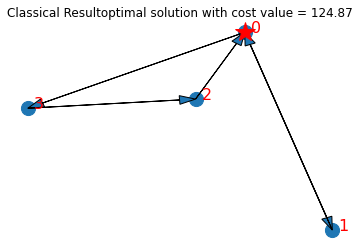

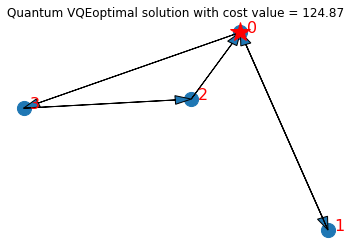

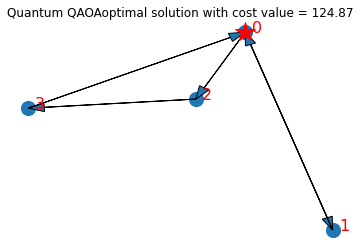

In [41]:
x_quantum_qaoa, solution_qaoa, cost_qaoa, x_quantum_vqe, solution_vqe, cost_vqe = cost_sol_step2(result_vqe, result_qaoa)

# visualize the solution 
visualize_solution(xc, yc, x_quantum_clas, cost_clas , n, K, 'Classical Result')                                                                                               
visualize_solution(xc, yc, x_quantum_vqe, cost_vqe , n, K, 'Quantum VQE')
visualize_solution(xc, yc, x_quantum_qaoa, cost_qaoa, n, K, 'Quantum QAOA')

## The Model 

Mathematically speaking, the vehicle routing problem (VRP) is a combinatorial problem, wherein the best routes from a depot to a number of clients and back to the depot are sought, given a number of available vehicles. There are a number of formulations possible, extending a number of formulations of the traveling salesman problem [Applegate et al, 2006]. Here, we present a formulation known as MTZ [Miller, Tucker, Zemlin, 1960]. 

Let $n$ be the number of clients (indexed as $1,\dots,n$), and $K$ be the number of available vehicles. Let $x_{ij} = \{0,1\}$ be the binary decision variable which, if it is $1$, activates the segment from node $i$ to node $j$. The node index runs from $0$ to $n$, where $0$ is (by convention) the depot. There are twice as many distinct decision variables as edges. For example, in a fully connected graph, there are $n(n+1)$ binary decision variables. 

If two nodes $i$ and $j$ have a link from $i$ to $j$, we write $i \sim j$. We also denote with $\delta(i)^+$ the set of nodes to which $i$ has a link, i.e., $j \in \delta(i)^+$ if and only if $i \sim j$. Similarly, we denote with 
$\delta(i)^-$ the set of nodes which are connected to $i$, in the sense that $j \in \delta(i)^-$ if and only if $j \sim i$. 

In addition, we consider continuous variables, for all nodes $i = 1,\dots, n$, denoted $u_i$. These variables are needed in the MTZ formulation of the problem to eliminate sub-tours between clients. 

The VRP can be formulated as:

$$
(VRP) \quad  f = \min_{\{x_{ij}\}_{i\sim j}\in \{0,1\}, \{u_i\}_{i=1,\dots,n}\in \mathbb{R}} \quad \sum_{i \sim j} w_{ij} x_{ij}
$$

subject to the node-visiting constraint:

$$
\sum_{j \in \delta(i)^+} x_{ij} = 1, \,\sum_{j \in \delta(i)^-} x_{ji} = 1,\, \forall i \in \{1,\dots,n\},
$$

the depot-visiting constraints:

$$
\sum_{i \in \delta(0)^+} x_{0i} = K, \, \sum_{j \in \delta(0)^+} x_{j0} = K,
$$

and the sub-tour elimination constraints:

$$
u_i - u_j + Q x_{ij} \leq Q-q_j, \, \forall i \sim j, \,i ,j \neq 0, \quad q_i \leq u_i \leq Q,\, \forall i, i \neq 0.
$$

In particular, 
- The cost function is linear in the cost functions and weighs the different arches based on a positive weight $w_{ij}>0$ (typically the distance between node $i$ and node $j$);
- The first set of constraints enforce that from and to every client, only one link is allowed;
- The second set of constraints enforce that from and to the depot, exactly  $K$ links are allowed;
- The third set of constraints enforce the sub-tour elimination constraints and are bounds on $u_i$, with $Q>q_j>0$, and $Q,q_i \in \mathbb{R}$.


## Classical solution

We can solve the VRP classically, e.g., by using CPLEX. CPLEX uses a branch-and-bound-and-cut method to find an approximate solution of the VRP, which, in this formulation, is a mixed-integer linear program (MILP). For the sake of notation, we pack the decision variables in one vector as

$$
{\bf z} = [x_{01},x_{02},\ldots,x_{10}, x_{12},\ldots,x_{n(n-1)}]^T,
$$

wherein ${\bf z} \in \{0,1\}^N$, with $N = n (n+1)$. So the dimension of the problem scales quadratically with the number of nodes. Let us denote the optimal solution by ${\bf z}^*$, and the associated optimal cost $f^*$. 


## Quantum solution

Here, we demonstrate an approach that combines classical and quantum computing steps, following the quantum approximate optimization approach of Farhi, Goldstone, and Gutman (2014). In particular, we use the variational quantum eigensolver (VQE). We stress that given the use of limited depth of the quantum circuits employed (variational forms), it is hard to discuss the speed-up of the algorithm, as the solution obtained is heuristic in nature. At the same time, due to the nature and importance of the target problems, it is worth investigating heuristic approaches, which may be worthwhile for some problem classes. 

Following [5], the algorithm can be summarized as follows:
- Preparation steps: 
	- Transform the combinatorial problem into a binary polynomial optimization problem with equality constraints only;
	- Map the resulting problem into an Ising Hamiltonian ($H$) for variables ${\bf z}$ and basis $Z$, via penalty methods if necessary;
	- Choose the depth of the quantum circuit $m$. Note that the depth can be modified adaptively.
	- Choose a set of controls $\theta$ and make a trial function $\big|\psi(\boldsymbol\theta)\rangle$, built using a quantum circuit made of C-Phase gates and single-qubit Y rotations, parameterized by the components of $\boldsymbol\theta$.


- Algorithm steps: 
	- Evaluate $C(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)\big|H\big|\psi(\boldsymbol\theta)\rangle$ by sampling the outcome of the circuit in the Z-basis and adding the expectation values of the individual Ising terms together. In general, different control points around $\boldsymbol\theta$ have to be estimated, depending on the classical optimizer chosen.
	- Use a classical optimizer to choose a new set of controls.
	- Continue until $C(\boldsymbol\theta)$ reaches a minimum, close enough to the solution $\boldsymbol\theta^*$.
	- Use the last $\boldsymbol\theta$ to generate a final set of samples from the distribution $\Big|\langle z_i\big|\psi(\boldsymbol\theta)\rangle\Big|^2\;\forall i$ to obtain the answer.


There are many parameters throughout, notably the choice of the trial wavefunction. Below, we consider:

$$
\big|\psi(\theta)\rangle = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m \big|+\rangle
$$

where $U_\mathrm{entangler}$ is a collection of C-Phase gates (fully-entangling gates), and $U_\mathrm{single}(\theta) = \prod_{i=1}^N Y(\theta_{i})$, where $N$ is the number of qubits and $m$ is the depth of the quantum circuit. 


### Construct the Ising Hamiltonian

From $VRP$ one can construct a binary polynomial optimization with equality constraints only by considering cases in which $K=n-1$. In these cases the sub-tour elimination constraints are not necessary and the problem is only on the variable ${\bf z}$. In particular, we can write an augmented Lagrangian as

$$
(IH) \quad H = \sum_{i \sim j} w_{ij} x_{ij}  + A \sum_{i \in \{1,\dots,n\}} \Big(\sum_{j \in \delta(i)^+} x_{ij} - 1\Big)^2 + A \sum_{i \in \{1,\dots,n\}}\Big(\sum_{j \in \delta(i)^-} x_{ji} - 1\Big)^2 +A \Big(\sum_{i \in \delta(0)^+} x_{0i} - K\Big)^2 + A\Big(\sum_{j \in \delta(0)^+} x_{j0} - K\Big)^2
$$

where $A$ is a big enough parameter. 

### From Hamiltonian to QP formulation 

In the vector ${\bf z}$, and for a complete graph ($\delta(i)^+ = \delta(i)^- = \{0,1,\dots,i-1,i+1,\dots,n\}$), $H$ can be written as follows.

$$
\min_{{\bf z}\in \{0,1\}^{n(n+1)}} {\bf w}^T {\bf z}  + A \sum_{i \in \{1,\dots,n\}} \Big({\bf e}_i \otimes {\bf 1}_n^T {\bf z} - 1\Big)^2 + A \sum_{i \in \{1,\dots,n\}}\Big({\bf v}_i^T {\bf z} - 1\Big)^2 + A \Big(({\bf e}_0 \otimes {\bf 1}_n)^T{\bf z} - K\Big)^2 + A\Big({\bf v}_0^T{\bf z} - K\Big)^2.
$$

That is:

$$
\min_{\bf z\in \{0,1\}^{n(n+1)}} \bf z^T {\bf Q} \bf z + {\bf g}^T \bf z + c,
$$

Where: first term:

$$
{\bf Q} = A \sum_{i \in \{0,1,\dots,n\}}  \Big[({\bf e}_i \otimes {\bf 1}_n)({\bf e}_i \otimes {\bf 1}_n)^T + {\bf v}_i{\bf v}_i^T \Big] 
$$

Second term:

$$
{\bf g} = {\bf w} -2 A \sum_{i \in \{1,\dots,n\}} \Big[({\bf e}_i \otimes {\bf 1}_n) + {\bf v}_i \Big] -2 A K \Big[({\bf e}_0 \otimes {\bf 1}_n) + {\bf v}_0 \Big]
$$

Third term:

$$
c = 2An +2AK^2.
$$

The QP formulation of the Ising Hamiltonian is ready for the use of VQE. We will solve the QP using optimization stack available in Qiskit.

## References 

[1] E. Farhi, J. Goldstone, S. Gutmann e-print arXiv 1411.4028, 2014

[2] https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/optimization/6_examples_max_cut_and_tsp.ipynb

[3] C. E. Miller, E. W. Tucker, and R. A. Zemlin (1960). "Integer Programming Formulations and Travelling Salesman Problems". J. ACM. 7: 326–329. doi:10.1145/321043.321046.

[4] D. L. Applegate, R. M. Bixby, V. Chvátal, and W. J. Cook (2006). The Traveling Salesman Problem. Princeton University Press, ISBN 978-0-691-12993-8.